In [1]:
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import r2_score
from itertools import product

import warnings
warnings.simplefilter('ignore')
warnings.filterwarnings('ignore')

import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller

from pylab import rcParams
rcParams['figure.figsize'] = 18, 8

In [8]:
def ADF(series):
    dftest = adfuller(series.dropna())
    print('adf: {:.3f}'. format(dftest[0]))
    print('p-value: {:.3f}'.format(dftest[1]))
    print('critical values: ', dftest[4])
    if dftest[0] > dftest[4]['5%']: 
        print('есть единичные корни, ряд не стационарен')
    else:
        print('единичных корней нет, ряд стационарен')

In [50]:
def additive(data):
    result = sm.tsa.seasonal_decompose(data.Value, model='additive')
    result.plot()
    plt.show()
    
    from random import randrange
    print("\nCheck the components:")
    print('Trend:')
    ADF(result.trend)

    print('')
    print('Seasonal:')
    ADF(result.seasonal)

    print('')
    print('Resid:')
    ADF(result.resid)

In [51]:
def multiplicative(data):
    result = sm.tsa.seasonal_decompose(data.Value, model='multiplicative')
    result.plot()
    plt.show()
    
    from random import randrange
    print("\nCheck the components:")
    print('Trend:')
    ADF(result.trend)

    print('')
    print('Seasonal:')
    ADF(result.seasonal)

    print('')
    print('Resid:')
    ADF(result.resid)

In [52]:
data_training = pd.read_excel('~/prac/training.xlsx', index_col='Date', parse_dates=True)
data_testing = pd.read_excel('~/prac/testing.xlsx', index_col='Date', parse_dates=True)
sns.set()

adf: -0.253
p-value: 0.932
critical values:  {'1%': -3.4489583388155194, '5%': -2.869739378430086, '10%': -2.5711381780459}
есть единичные корни, ряд не стационарен


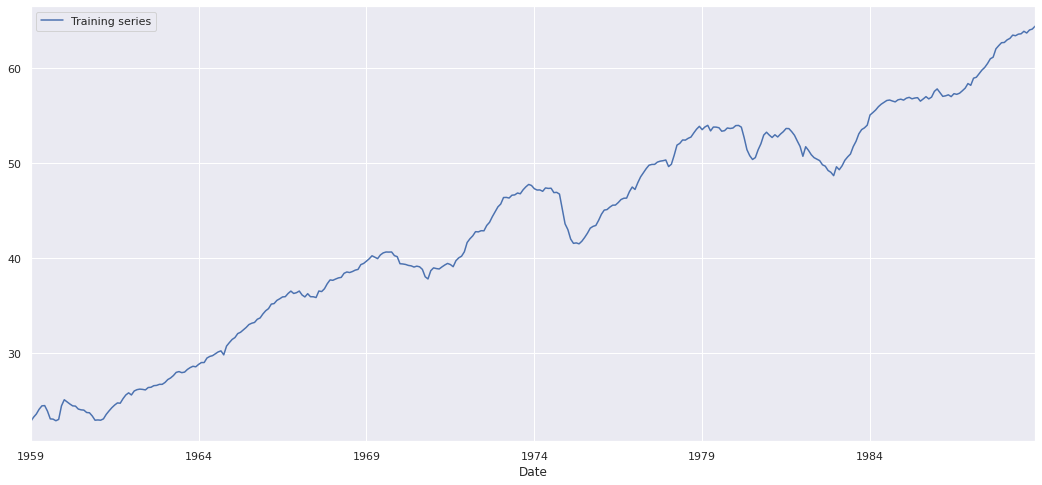

In [53]:
ADF(data_training)
data_training.Value.plot(label='Training series')
plt.legend(loc='upper left')
plt.show()

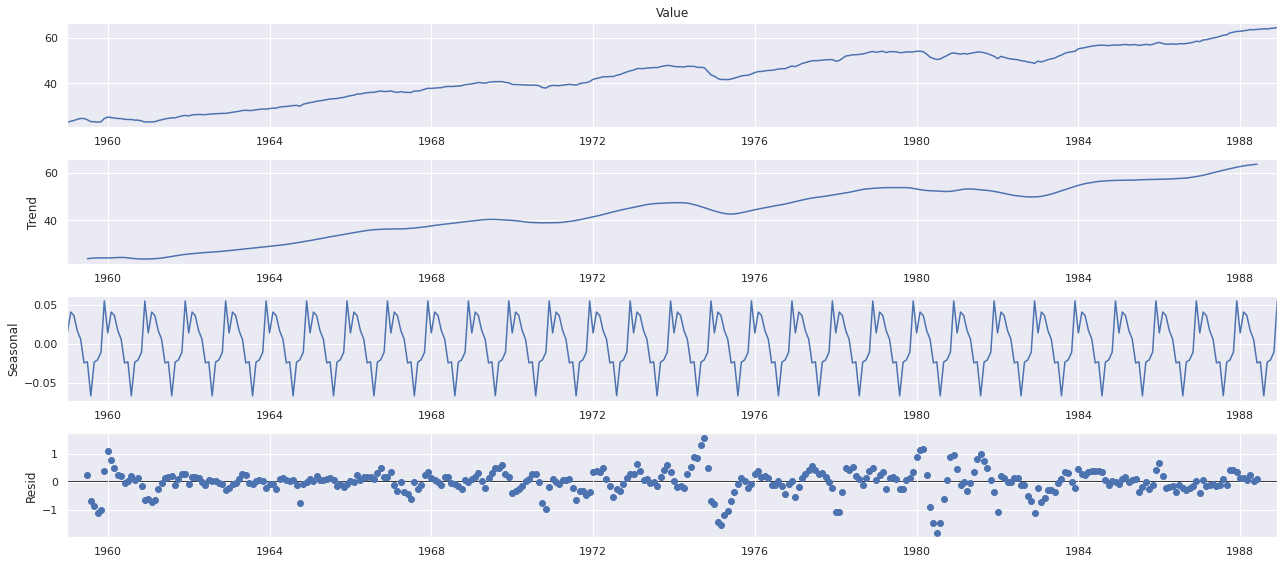


Check the components:
Trend:
adf: -0.862
p-value: 0.800
critical values:  {'1%': -3.4503224123605194, '5%': -2.870338478726661, '10%': -2.571457612488522}
есть единичные корни, ряд не стационарен

Seasonal:
adf: -347276279887814.750
p-value: 0.000
critical values:  {'1%': -3.4492815848836296, '5%': -2.8698813715275406, '10%': -2.5712138845950587}
единичных корней нет, ряд стационарен

Resid:
adf: -7.486
p-value: 0.000
critical values:  {'1%': -3.4496162602188187, '5%': -2.870028369720798, '10%': -2.5712922615505627}
единичных корней нет, ряд стационарен


In [54]:
additive(data_training)

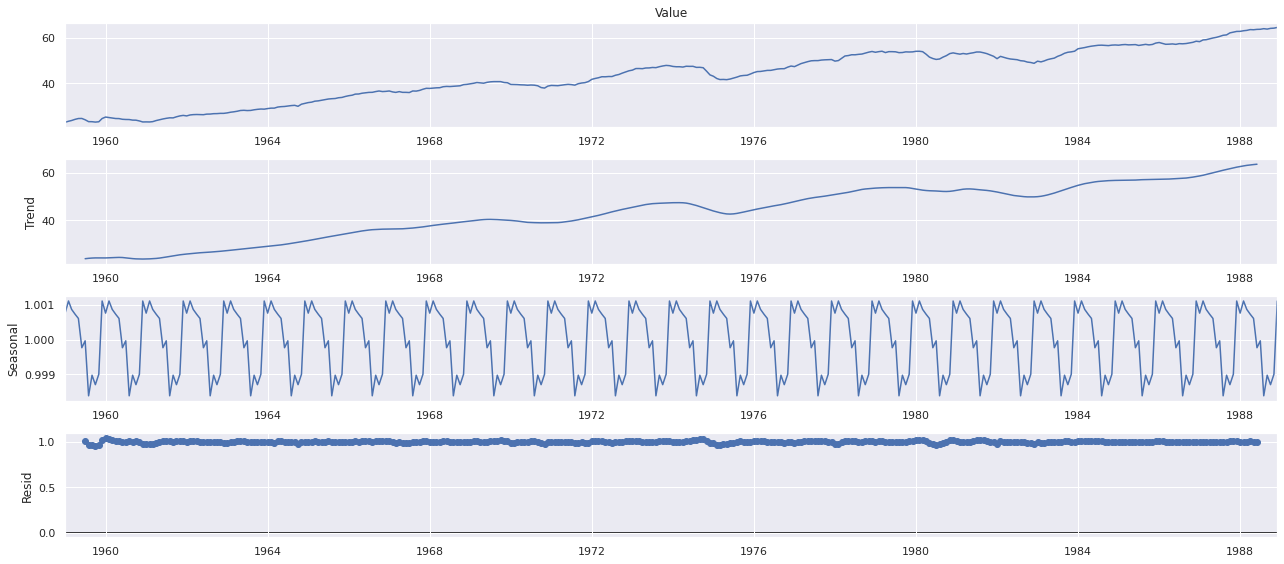


Check the components:
Trend:
adf: -0.862
p-value: 0.800
critical values:  {'1%': -3.4503224123605194, '5%': -2.870338478726661, '10%': -2.571457612488522}
есть единичные корни, ряд не стационарен

Seasonal:
adf: -36740380766035.297
p-value: 0.000
critical values:  {'1%': -3.449559661646851, '5%': -2.8700035112469626, '10%': -2.5712790073013796}
единичных корней нет, ряд стационарен

Resid:
adf: -7.466
p-value: 0.000
critical values:  {'1%': -3.4496162602188187, '5%': -2.870028369720798, '10%': -2.5712922615505627}
единичных корней нет, ряд стационарен


In [56]:
multiplicative(data_training)

adf: -7.367
p-value: 0.000
critical values:  {'1%': -3.4489583388155194, '5%': -2.869739378430086, '10%': -2.5711381780459}
единичных корней нет, ряд стационарен


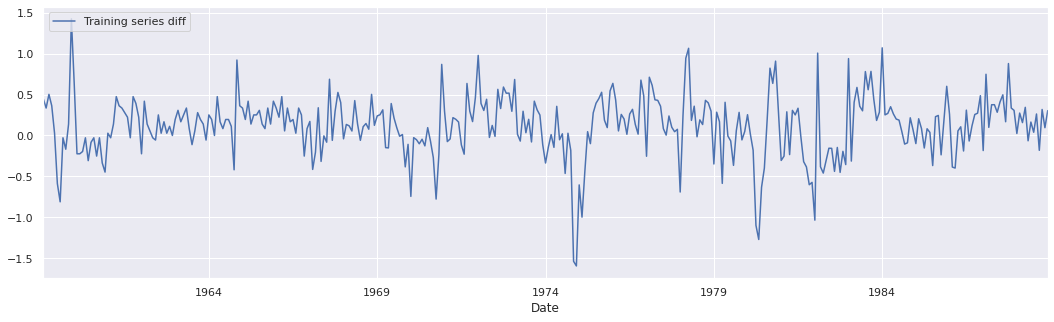

In [57]:
data_training_diff = data_training.Value.diff(periods=1).dropna()
ADF(data_training_diff)
data_training_diff.plot(label='Training series diff', figsize=(18,5))
plt.legend(loc='upper left')
plt.show()

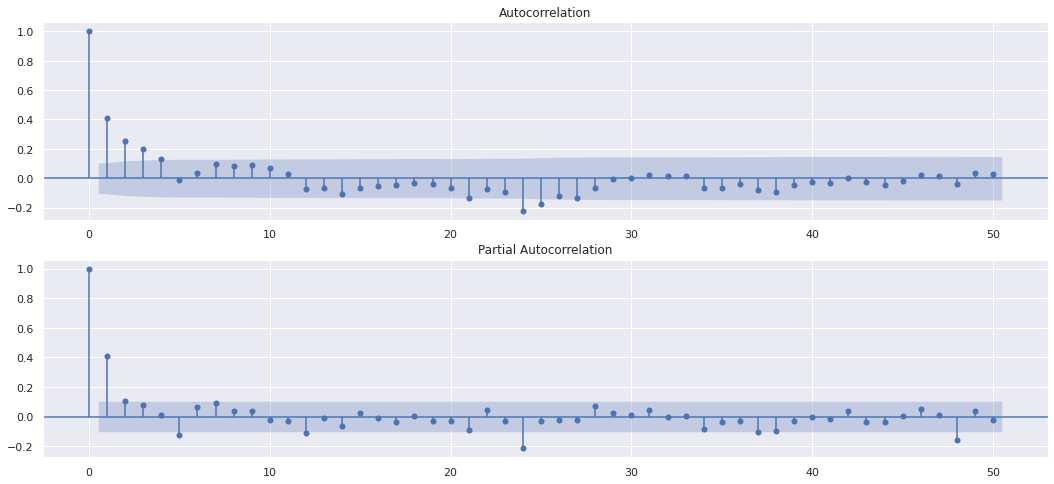

In [58]:
fig = plt.figure()
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(data_training_diff.squeeze(), lags=50, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(data_training_diff.squeeze(), lags=50, ax=ax2)

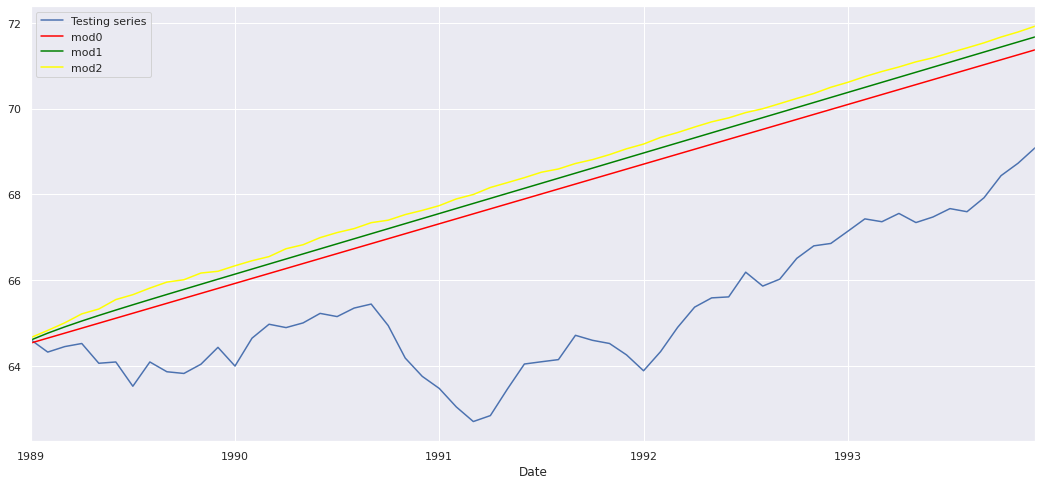

AIC model0: 315.986
AIC model1: 248.734
AIC model2: 250.599
r2_0 R^2: -2.683
r2_1 R^2: -3.281
r2_2 R^2: -3.851
CPU times: user 3min 11s, sys: 7.6 s, total: 3min 19s
Wall time: 50.6 s


In [62]:
%%time

model_0 = sm.tsa.ARIMA(data_training, order=(0,1,0), freq='MS').fit()
model_1 = sm.tsa.ARIMA(data_training, order=(1,1,1), freq='MS').fit()
model_2 = sm.tsa.ARIMA(data_training, order=(12,1,4), freq='MS').fit()

pred_0 = model_0.predict('1989-01-01','1993-12-01', typ='levels')
pred_1 = model_1.predict('1989-01-01','1993-12-01', typ='levels')
pred_2 = model_2.predict('1989-01-01','1993-12-01', typ='levels')

data_testing.Value.plot(label='Testing series')
pred_0.plot(color='red', label='mod0')
pred_1.plot(color='green', label='mod1')
pred_2.plot(color='yellow', label='mod2')
plt.legend(loc='upper left')
plt.show()

print('AIC model0: %1.3f' % model_0.aic)
print('AIC model1: %1.3f' % model_1.aic)
print('AIC model2: %1.3f' % model_2.aic)

r2_0 = r2_score(data_testing, pred_0)
r2_1 = r2_score(data_testing, pred_1)
r2_2 = r2_score(data_testing, pred_2)
print('r2_0 R^2: %1.3f' % r2_0)
print('r2_1 R^2: %1.3f' % r2_1)
print('r2_2 R^2: %1.3f' % r2_2)

In [63]:
%%time
ps = range(0, 2)
d=1
qs = range(0, 4)

parameters = product(ps, qs)
parameters_list = list(parameters)

results = []
best_aic = float("inf")

for param in parameters_list:
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.ARIMA(data_training.Value, order=(param[0], d, param[1]),  freq='MS').fit()
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])

CPU times: user 1.34 s, sys: 59.8 ms, total: 1.4 s
Wall time: 658 ms


In [64]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True))

  parameters         aic
5     (1, 1)  248.733657
6     (1, 2)  250.623522
7     (1, 3)  251.083211
4     (1, 0)  251.982662
3     (0, 3)  254.652487
2     (0, 2)  259.218223
1     (0, 1)  267.450283
0     (0, 0)  315.985631


In [65]:
print(best_model.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Value   No. Observations:                  359
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -120.367
Method:                       css-mle   S.D. of innovations              0.338
Date:                Sat, 19 Dec 2020   AIC                            248.734
Time:                        13:51:29   BIC                            264.267
Sample:                    02-01-1959   HQIC                           254.911
                         - 12-01-1988                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.1176      0.036      3.271      0.001       0.047       0.188
ar.L1.D.Value     0.6531      0.091      7.185      0.000       0.475       0.831
ma.L1.D.Value    -0.2984      0.115     

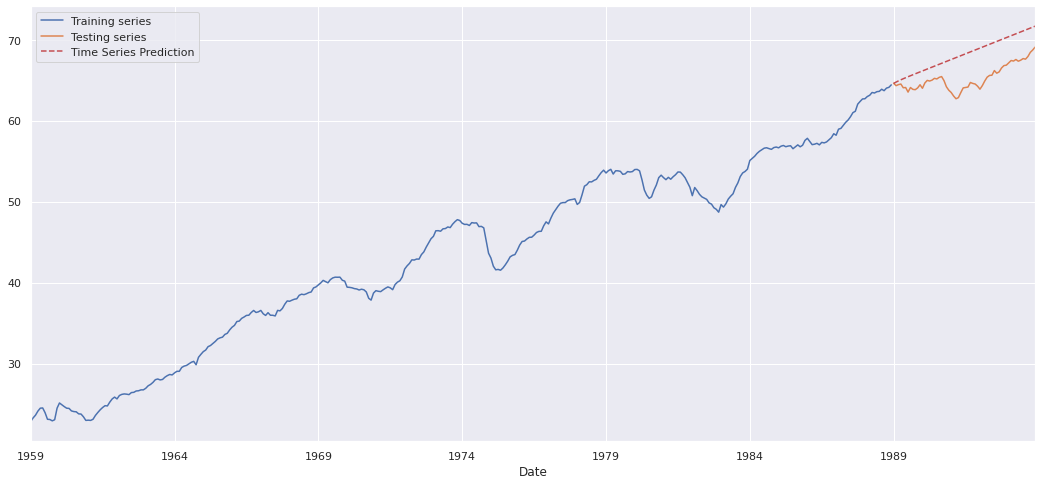

In [66]:
data_training.Value.plot(label='Training series')
data_testing.Value.plot(label='Testing series')

pred = best_model.predict('1989-01-01','1993-12-01', typ='levels')
pred.plot(label='Time Series Prediction', style='r--')

plt.legend(loc='upper left')
plt.show()

In [67]:
r2 = r2_score(data_testing.Value, pred)
print('R^2: %1.3f' % r2)

R^2: -3.281
